In [ ]:
!pip install tensorflow==2.9.1 keras==2.9.0

In [20]:
!pip install transformers
!pip install verovio
!pip install tiktoken

In [21]:
!unzip archive.zip -d /content/archive

Archive:  archive.zip
replace /content/archive/License-Characters-by-2-27classes/test/ckicup6z1000g246a7fphj2ry.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [23]:
import random
import string
import math
import itertools
import os
import numpy as np
import pandas as pd
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import xml.etree.ElementTree as ET
import cv2
import torch

In [24]:
# Define the directory where the XML files and images are stored
xml_dir = '/content/archive/License-Characters-by-2-27classes/train'  # Update with the correct path
image_dir = '/content/archive/License-Characters-by-2-27classes/train'  # Update with the correct path

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text

    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)

    return filename, labels

def has_three_alphabets(labels):
    alphabet_count = sum([1 for label in labels if label.isalpha()])
    return alphabet_count == 3

image_labels = []
for xml_filename in os.listdir(xml_dir):
    if xml_filename.endswith('.xml'):
        xml_file_path = os.path.join(xml_dir, xml_filename)

        image_filename, labels = parse_xml(xml_file_path)

        if has_three_alphabets(labels):
            image_path = os.path.join(image_dir, image_filename)
            image_labels.append((image_path, labels))

In [25]:
image_labels[1]

('/content/archive/License-Characters-by-2-27classes/train/ckid1olht003f246a08lmevod.jpeg',
 ['3', '3', '3', '8', 'T', 'N', 'J'])

In [ ]:
#batch_size = 8
#
#def format_labels_for_ocr(image_labels):
#    formatted_labels = []
#    for image_path, labels in image_labels:
#        text_label = ''.join(labels)
#        formatted_labels.append((image_path, None, text_label))
#    return formatted_labels
#
#train_data = sklearn.model_selection.train_test_split(image_labels, test_size=0.2, random_state=42)
#
#formatted_train_data = format_labels_for_ocr(train_data)
##formatted_validation_data = format_labels_for_ocr(validation_data)
#
#augmenter = imgaug.augmenters.Sequential([
#    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
#])
#
##def format_data_for_keras_ocr(data, recognizer):
##    image_gen = keras_ocr.datasets.get_recognizer_image_generator(
##        labels=data,
##        height=recognizer.model.input_shape[1],
#        width=recognizer.model.input_shape[2],
#        alphabet=recognizer.alphabet,
#        augmenter=augmenter
#    )
#    steps = len(data) // batch_size
#    return recognizer.get_batch_generator(
#        image_generator=image_gen,
#        batch_size=batch_size
#    ), steps
#

In [26]:
batch_size = 8

def format_labels_for_ocr(image_labels):
    formatted_labels = []
    # Iterate through the data splits (training and testing)
    for data_split in image_labels:
        # Iterate through the image-label pairs in the current split
        for image_path, labels in data_split:
            text_label = ''.join(labels)
            formatted_labels.append((image_path, text_label))
    return formatted_labels

train_data, _ = sklearn.model_selection.train_test_split(image_labels, test_size=0.2, random_state=42) # Only keep training data

formatted_train_data = format_labels_for_ocr([train_data]) # Wrap train_data in a list to mimic the structure of the original split

In [27]:
formatted_train_data = pd.DataFrame(formatted_train_data, columns=['image_path', 'text_label'])
formatted_train_data

,image_path,text_label
0,/content/archive/License-Characters-by-2-27cla...,7980ESJ
1,/content/archive/License-Characters-by-2-27cla...,DRA3580
2,/content/archive/License-Characters-by-2-27cla...,3754VLJ
3,/content/archive/License-Characters-by-2-27cla...,5732NXD
4,/content/archive/License-Characters-by-2-27cla...,6134GLD
...,...,...
372,/content/archive/License-Characters-by-2-27cla...,2260GVJ
373,/content/archive/License-Characters-by-2-27cla...,6507EGB
374,/content/archive/License-Characters-by-2-27cla...,350DDB
375,/content/archive/License-Characters-by-2-27cla...,9454BKJ


In [28]:
# Load model directly
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("stepfun-ai/GOT-OCR2_0", trust_remote_code=True)
OCR_model = AutoModel.from_pretrained("stepfun-ai/GOT-OCR2_0", trust_remote_code=True)

In [29]:
images_paths = formatted_train_data['image_path'].astype(str).tolist()
plate_numbers = formatted_train_data['text_label'].astype(str).tolist()

In [33]:
# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OCR_model.to(device)

GOTQwenForCausalLM(
  (model): GOTQwenModel(
    (embed_tokens): Embedding(151860, 1024)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (up_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (down_proj): Linear(in_features=2816, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1024,), eps=1e-06)
      )
    )
    (nor

In [34]:
producted_plate_number = []
for i in range(len(images_paths)):
  res = OCR_model.chat(tokenizer, images_paths[i], ocr_type='ocr')
  producted_plate_number.append(res.replace(' ', ''))

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
#recognizer = keras_ocr.recognition.Recognizer(alphabet='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
#recognizer.compile()
#recognizer.model.load_weights('/content/OCR_KERAS_MODEL.h5')
#
# recognizer = load_model('/content/OCR_KERAS_MODEL.h5').Recognizer(alphabet='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
# recognizer.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [ ]:
(training_gen, training_steps), (validation_gen, validation_steps) = [
    format_data_for_keras_ocr(data, recognizer) for data in [formatted_train_data, formatted_validation_data]
]

In [ ]:
image, text = next(training_gen)
plt.imshow(image[0][0].squeeze())

NameError: name 'training_gen' is not defined

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint('recognizer_saudi_license_plate.h5', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_training_log.csv')
]

recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=20
)

Epoch 1/20


<ipython-input-37-b6560d9f96b2>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  recognizer.training_model.fit_generator(


47/47 [==============================] - 257s 5s/step - loss: 1.4527 - val_loss: 9.3151
Epoch 2/20
47/47 [==============================] - 233s 5s/step - loss: 0.9590 - val_loss: 9.4288
Epoch 3/20
42/47 [=========================>....] - ETA: 23s - loss: 0.9930

1/1 [==============================] - 0s 305ms/step
Predicted License Plate Text: 838DRA


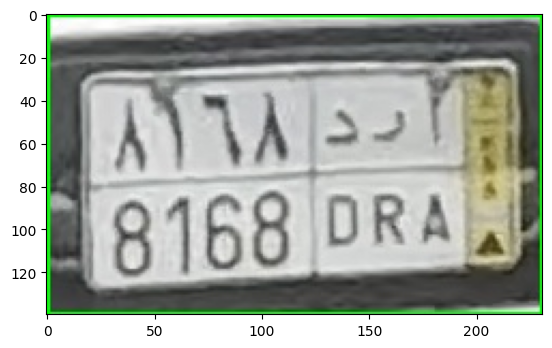

In [ ]:
image_filepath = '/content/1.jpg'
predicted = recognizer.recognize(image_filepath)
plt.imshow(keras_ocr.tools.read(image_filepath))
print(f'Predicted License Plate Text: {predicted}')

In [ ]:
recognizer.model.save('OCR_KERAS_MODEL.h5')

## Testing Later

In [ ]:
image_filepath, _, actual = test_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

In [ ]:
recognizer.model.load_weights('recognizer_borndigital.h5')